<a href="https://colab.research.google.com/github/JulianSchmidtke/CAPTUM/blob/main/AsuD_CAPTUM_v0.1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [63]:
%matplotlib inline
import matplotlib.pyplot as plt
import nltk, os
import pandas as pd
import numpy as np
import re
from collections import Counter
import shutil

In [64]:
os.chdir(r'/content')

content_dir = r'/content/CAPTUM/'

# Remove if files already exist
while os.path.exists(content_dir): 
    shutil.rmtree(content_dir)


!git clone https://github.com/JulianSchmidtke/CAPTUM.git

Cloning into 'CAPTUM'...
remote: Enumerating objects: 550, done.
remote: Counting objects: 100% (550/550), done.
remote: Compressing objects: 100% (527/527), done.
remote: Total 550 (delta 43), reused 463 (delta 20), pack-reused 0
Receiving objects: 100% (550/550), 11.76 MiB | 9.78 MiB/s, done.
Resolving deltas: 100% (43/43), done.


# Duplikate unter den Papern entfernen anhand der Hash-Werte

In [65]:
#Arbeitsverzeichnis auf das Ordnerverzeichnis ändern, in welchem die Daten liegen (txt-Format)
file_dir = r'/content/CAPTUM/files'
os.chdir(file_dir)

#Speichern der Dateinamen in einem Array
files = os.listdir()
df_files = pd.DataFrame(files, columns=['Filepath'])

In [66]:
# create checksum for each file to identify duplicates
# https://stackoverflow.com/questions/16874598/how-do-i-calculate-the-md5-checksum-of-a-file-in-python#16876405
import hashlib
def get_checksum(filepath: str) -> str:
    # Open,close, read file and calculate MD5 on its contents 
    with open(filepath, 'rb') as file_to_check:
        # read contents of the file
        data = file_to_check.read()    
        # pipe contents of the file through
        return hashlib.md5(data).hexdigest()
df_files['Checksum'] = df_files['Filepath'].apply(get_checksum)

In [67]:
fileNameTags = list(map(lambda fn: fn.replace('', '+').split('_')[0:-2],df_files['Filepath']))


df_files['Name'] = [fNT[-1] for fNT in fileNameTags]
df_files['Tags'] = [fNT[1:-1] for fNT in fileNameTags]
df_files['Year'] = [fY[-8:-4] for fY in df_files['Name']]
df_files['Authors'] = [fN.split(' ')[0] for fN in df_files['Name']]

In [68]:
#Den Inhalt der Paper einlesen und in einen Pandas-
df_files['Content'] = df_files['Filepath'].apply(lambda f: open(f, 'r', encoding = "ISO-8859-1").read())
df_files

,Filepath,Checksum,Name,Tags,Year,Authors,Content
0,CAPTUM_D-Dimer_Cyclosporine_Asero 2015.pdf_out...,d7b3b50de0769f50a24abd3a85caba95,Asero 2015.pdf,"[D-Dimer, Cyclosporine]",2015,Asero,"J ALLERGY CLIN IMMUNOL\nVOLUME 135, NUMBER 5\n..."
1,CAPTUM_Allergic Diseases_Angioedema_Cousin 201...,dfe2de2f866e6b8fda6f0f10a246e85c,Cousin 2016.pdf,"[Allergic Diseases, Angioedema]",2016,Cousin,Received Date : 11-Jan-2016\nRevised Date : 27...
2,CAPTUM_Angioedema_Antihistamine_Serarslan 2018...,cd26e092884ca85a7adf85b7306fe707,Serarslan 2018.pdf,"[Angioedema, Antihistamine]",2018,Serarslan,Angioedema is an unfavorable factor for the re...
3,CAPTUM_Allergic Diseases_Omalizumab_Saini 2011...,62f9284d2c4fc80c37a770c9fc4f17a4,Saini 2011.pdf,"[Allergic Diseases, Omalizumab]",2011,Saini,Atopic dermatitis and skin disease\n\nA random...
4,CAPTUM_ASST_BHRA_Santos 2012.pdf_out_text.txt,3ac77ce0317fe25cb47eb23243223b17,Santos 2012.pdf,"[ASST+, BHRA]",2012,Santos,Clinical & Experimental Immunology\n\nimmunolo...
...,...,...,...,...,...,...,...
1041,CAPTUM_Severity_Omalizumab_Deza 2017.pdf_out_t...,1a5c1b616c12e9b9771c99e6ceb8d214,Deza 2017.pdf,"[Severity, Omalizumab]",2017,Deza,Acta Dermato-Venereologica\n\nBB\nFE\n(=)\n2\n...
1042,CAPTUM_Total IgE_Allergic Diseases_Deza 2017.p...,1a5c1b616c12e9b9771c99e6ceb8d214,Deza 2017.pdf,"[Total IgE, Allergic Diseases]",2017,Deza,Acta Dermato-Venereologica\n\nBB\nFE\n(=)\n2\n...
1043,CAPTUM_ASST_Anti-IgE_Guttman-Yassky 2007.pdf_...,8633e3af86b91f35edbadeede380d037,Guttman-Yassky 2007.pdf,"[ASST+, Anti-IgE]",2007,Guttman-Yassky,ORIGINAL ARTICLE\n\nJEADV ISSN 1468-3083\n\nTh...
1044,CAPTUM_Total IgE_Basophil_Uysal 2016.pdf_out_t...,a86431127af09c8de0863de2f261a361,Uysal 2016.pdf,"[Total IgE, Basophil]",2016,Uysal,198\n\nOriginal Articl¢\n\n \n\nTURK A\nPEDIAT...


In [69]:
checksums = df_files['Checksum'].unique()
for checksum in checksums:
    tags = df_files.loc[df_files['Checksum'] == checksum, 'Tags']
    list_of_pair_of_tags = tags.values.ravel()
    list_of_tags = [tag for tags in list_of_pair_of_tags for tag in tags]
    unique_tags = pd.unique(list_of_tags)
    df_files.loc[df_files['Checksum'] == checksum, 'Tags'] = ', '.join(map(str, unique_tags))

In [70]:
# create dataframe for further analytics w/o the duplicate articles
df = df_files.drop_duplicates(subset=['Checksum'], keep='first')
df.reset_index(inplace=True, drop=True)
df = df.loc[:,['Authors','Year','Tags', 'Content']]

# Korpus erstellen

In [71]:
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Es werden Füllwörter entfernt.

In [72]:
stop_words=set(stopwords.words("english"))
def stoppingFunc(text, stop_words=stop_words):
    filtered_text=[]
    for word in text:
        # Wort unter 3 Zeichen -> weg
        if len(word) < 3:
          next
        # Mehr als eine Ziffer -> weg
        elif sum(c.isdigit() for c in word)>1:
          next
        # nicht in Stopword Liste -> behalten
        elif word not in stop_words:
          filtered_text.append(word)
        
    return filtered_text

Wörter auf ihren Wortstamm reduzieren (cats -> cat, transportation -> transport)

In [73]:
def stemmingFunc(text):
    stemmer = PorterStemmer()
    return [stemmer.stem(word) for word in text]

Komplexere Version des Stemming. Wörter werden im Zusammenhang gesehen und reduziert. Verben werden auf den Infiitiv gesetzt usw.

In [74]:
def lemmatizingFunc(text):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in text]

In [75]:
def removeWords(text):
  filtered_text=[]
  for word in text:
    if word.lower() in ('csu', 'urticaria', 'doi', 'http', 'the', 'al', 'fig', 
                        'point', 'data', 'patient', 'result', 'study', 'disease', 
                        'result', 'group', 'table', 'figure', 'patient'):
      next
    else:
      filtered_text.append(word)

  counter = Counter(filtered_text)
  filtered_text = [key for key, val in counter.items() if val > 1]

  return filtered_text

In [76]:
def remove_doi(text):
  doi_regex = r"10.\d{4,9}\/[-._;()\/:A-Z0-9]+$"
  new_text = re.sub(doi_regex, '', text, flags=re.IGNORECASE)
  return new_text

In [77]:
removeWords(['csu', 'TEST', 'DOI', 'doi', 'al', 'DOI'])

[]

In [78]:
def normalize_text(tokenizer, text):
  # lowercase text
  text = str(text).lower()
  # remove non-UTF
  text = text.encode("utf-8", "ignore").decode()
  # remove doi
  text = remove_doi(text)

  tokenized_text = tokenizer.tokenize(text)

  tokenized_text = removeWords(tokenized_text)
  tokenized_text = stoppingFunc(tokenized_text)
  #tokenized_text = stemmingFunc(tokenized_text)
  tokenized_text = lemmatizingFunc(tokenized_text)

  text = " ".join(tokenized_text)
  return text

In [79]:
def remove_word_in_every_corpus(corpus, series):
  words = set(series)
  print(words)
  return




  new_corpus = []
  for word in corpus:
    in_every_corpus = True
    for element in series:
      if not word in element:
        in_every_corpus = False
    if in_every_corpus:
      new_corpus += word
  return new_corpus

Ich glaube es sollte entweder eine Stemming oder eine Lemmatizing Funktion angewendet werden.

Ich glaube wir sollten erst Lemmatizen und dann Stopwords entfernen.

In [80]:
regex_tokenizer = nltk.RegexpTokenizer("\w+")
df['Corpus'] = df['Content'].apply(lambda c: normalize_text(regex_tokenizer, c))

# Corpus aufräumen 
#df['Corpus'] = df['Corpus'].apply(lambda c: remove_word_in_every_corpus(c, df['Content']))


regex_tokenizer2 = nltk.RegexpTokenizer('\w+[\.,]{0,1}')
df['Corpus_w_Punctuation'] = df['Content'].apply(lambda c: normalize_text(regex_tokenizer2, c))


In [81]:
corpus_list = df['Content'].to_list()
remove_word_in_every_corpus('', corpus_list)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [82]:
df

,Authors,Year,Tags,Content,Corpus,Corpus_w_Punctuation
0,Asero,2015,"D-Dimer, Cyclosporine","J ALLERGY CLIN IMMUNOL\nVOLUME 135, NUMBER 5\n...",allergy clin immunol volume number plasma dime...,allergy clin immunol volume number plasma dime...
1,Cousin,2016,"Allergic Diseases, Angioedema",Received Date : 11-Jan-2016\nRevised Date : 27...,date accepted may article type phenotypical ch...,date accepted may article type phenotypical ch...
2,Serarslan,2018,"Angioedema, Antihistamine, Duration, Omalizumab",Angioedema is an unfavorable factor for the re...,angioedema unfavorable factor response omalizu...,angioedema unfavorable factor response omalizu...
3,Saini,2011,"Allergic Diseases, Omalizumab, Severity",Atopic dermatitis and skin disease\n\nA random...,atopic skin randomized placebo controlled dose...,"atopic skin randomized, placebo controlled, do..."
4,Santos,2012,"ASST+, BHRA",Clinical & Experimental Immunology\n\nimmunolo...,clinical experimental immunology regulation ch...,clinical experimental immunology regulation ch...
...,...,...,...,...,...,...
449,Kikuchi,2001,"BHRA, Basophil",Dermatologic and ocular diseases\n\nMechanisms...,disease mechanism autoimmune activation basoph...,disease mechanism autoimmune activation basoph...
450,Chanprapaph,018,"ASST+, TPO",Hindawi\n\nBioMed Research International\n\nVo...,hindawi biomed research international article ...,hindawi biomed research international article ...
451,Fadaee,2020,"Severity, Angioedema",ORIGINAL ARTICLE\n\nIran J Allergy Asthma Immu...,article iran allergy asthma immunol february i...,article iran allergy asthma immunol february i...
452,Degirmenci,2017,"ASST+, serverity+",Original paper\n\nAnalysis of the association ...,analysis association chronic spontaneous inter...,analysis association chronic spontaneous inter...


# Wordcloud


In [ ]:
!pip install wordcloud

from wordcloud import WordCloud

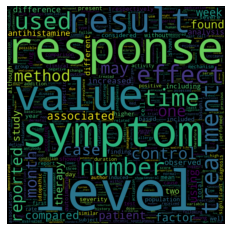

In [ ]:
words = ' '.join(list(df['Corpus']))
wordcloud = WordCloud(width=1000, height=1000, max_words=1000).generate(words)
wordcloud.to_file("../../first_review.png")

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Distinct Tags

In [190]:
type(list(df['Tags']))
tags = set(', '.join(list(df['Tags'])).split(', '))
print(*tags, sep="\n")

Basophil
cyclosporine
Eosinophil
Ana
thyroglobulin
angioedema
dsDNA
Allergic Diseases
Omalizumab
CRP
TPO
D-Dimer
IL-24
Angioedema
Duration
BHRA
Total IgE
duration
ASST+
serverity+
ANA
BAT
Eosinophil count
Antihistamine
Cyclosporine
Thyroglobulin
Tissue factor
anti-TPO IgE ratio+
Anti-IgE
omalizumab
Basophil count
Severity
anti-FcεRI


# Algorithmen anwenden

### ScispaCy

In [ ]:
!pip install spacy==3.1.0
!pip install scispacy==0.4.0
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_ner_bionlp13cg_md-0.4.0.tar.gz
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_core_sci_sm-0.4.0.tar.gz

     |████████████████████████████████| 6.4 MB 3.8 MB/s 
     |████████████████████████████████| 621 kB 43.6 MB/s 
     |████████████████████████████████| 42 kB 1.4 MB/s 
     |████████████████████████████████| 456 kB 26.5 MB/s 
     |████████████████████████████████| 10.1 MB 47.9 MB/s 
  Attempting uninstall: catalogue
    Found existing installation: catalogue 1.0.0
    Uninstalling catalogue-1.0.0:
      Successfully uninstalled catalogue-1.0.0
  Attempting uninstall: srsly
    Found existing installation: srsly 1.0.5
    Uninstalling srsly-1.0.5:
      Successfully uninstalled srsly-1.0.5
  Attempting uninstall: thinc
    Found existing installation: thinc 7.4.0
    Uninstalling thinc-7.4.0:
      Successfully uninstalled thinc-7.4.0
  Attempting uninstall: spacy
    Found existing installation: spacy 2.2.4
    Uninstalling spacy-2.2.4:
      Successfully uninstalled spacy-2.2.4
     |████████████████████████████████| 44 kB 1.1 MB/s 
     |████████████████████████████████| 71 kB 3.

In [ ]:
import spacy
import scispacy

from spacy import displacy
from scispacy.abbreviation import AbbreviationDetector
from scispacy.linking import EntityLinker
from collections import OrderedDict, Counter
from pprint import pprint


In [ ]:

def display_entities(model, document):
  doc = nlp(document)
  displacy_image = displacy.render(doc, jupyter=True, style='ent')
  entity_and_label = set([(X.text, X.label_) for X in doc.ents])
  return displacy_image, entity_and_label

In [ ]:
#As an example print the first Corpus from the df with the recogniced entities.
nlp = spacy.load('en_ner_bionlp13cg_md')
entities = display_entities(nlp, df['Corpus_w_Punctuation'][0])

In [ ]:
entities_dataframe = pd.DataFrame(entities[1],columns=['Entity','Label'])
entities_dataframe

,Entity,Label
0,skin,ORGAN
1,immunoglobulin fceri surface mast,GENE_OR_GENE_PRODUCT
2,cell noga,CELLULAR_COMPONENT
3,corticosteroids,SIMPLE_CHEMICAL
4,line,CELL
5,patients,ORGANISM
6,corticosteroid frequent must angioedema,SIMPLE_CHEMICAL
7,omalizumab,SIMPLE_CHEMICAL
8,thyroid peroxidase,CANCER
9,antihistamine first,GENE_OR_GENE_PRODUCT


In [ ]:
def entity_linker(linker_name,document):
  """A function tha accepts the name of a scispacy knowledgebase and 
  documents and returns the entity link details"""
  
  doc = nlp(document)
  try: 
    entity = doc.ents[0]
  except IndexError:
    entity = 'NaN'
  entity_details = []
  entity_details.append(entity)
  try:
    for linker_ent in entity._.kb_ents:
      Concept_Id, Score = linker_ent
      entity_details.appen('Entity_matching_Score :{}'.format(Score))
      entity_details.append(linker.kb.cui_to_entity[linker_ent[linker_ent[0]]])
  except AttributeError:
    pass
  return entity_details

In [ ]:
nlp = spacy.load('en_ner_bionlp13cg_md')
nlp.add_pipe("scispacy_linker", config={"resolve_abbreviations": True, "linker_name": "umls"}) #parameters are tunable, so it can be set to return more than 2 entity matches.
doc = df['Corpus_w_Punctuation'][0]
doc = nlp(doc)

entity = doc.ents[0]

linker = nlp.get_pipe("scispacy_linker")
for ent in entity._.kb_ents:
	print(linker.kb.cui_to_entity[ent[0]])


### Bag of Words
Quelle: [towardsdatascience](https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24)

In [ ]:
import gensim
import numpy as np
np.random.seed(2021)
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
processed_docs = df['Corpus'].apply(lambda c: c.split(' '))

In [ ]:
dictionary = gensim.corpora.Dictionary(processed_docs)
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 _http
1 aair
2 aairorg
3 able
4 academy
5 accepted
6 according
7 achieve
8 achieved
9 achieving
10 acta


### **LDA** (LatentDirichletAllocation) 
Quelle: [Medium-Artikel zu LDA](https://towardsdatascience.com/nlp-with-lda-latent-dirichlet-allocation-and-text-clustering-to-improve-classification-97688c23d98)

In [ ]:
#Turn tags into a set for faster checking of whether a tag exists or not
type(list(df['Tags']))
unique_tags = set(', '.join(list(df['Tags'])).split(', '))
print(*unique_tags, sep="\n")


Angioedema
Antihistamine
Omalizumab
Anti-IgE
Severity
Total IgE
TPO
anti-FcεRI
Ana
ASST+
CRP
serverity+
duration
Basophil count
BAT
Eosinophil count
Tissue factor
omalizumab
Duration
thyroglobulin
Allergic Diseases
dsDNA
Thyroglobulin
angioedema
anti-TPO IgE ratio+
Basophil
BHRA
Cyclosporine
D-Dimer
IL-24
cyclosporine
Eosinophil
ANA


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA


def find_topics(text):
  count_vectorizer = CountVectorizer()
  count_data = count_vectorizer.fit_transform(list(text))


  # One topic that has an avg of two words because most questions had 1/2 tags
  number_topics = 5
  number_words = 20

  # Create and fit the LDA model
  lda = LDA(n_components=number_topics, n_jobs=-1)
  lda.fit(count_data)
  words = count_vectorizer.get_feature_names()

  #Get topics from model. They are represented as a list e.g. ['military','army']
  topics = [[words[i] for i in topic.argsort()[:-number_words - 1:-1]] for (topic_idx, topic) in enumerate(lda.components_)]
  topic_groups = topics

  topics = np.array(topics).ravel()
  distinct_topics = list(set(topics))

  #Only use topics for which a tag already exists
  existing_topics = set.intersection(set(topics),unique_tags)

  

  return (words, distinct_topics, topic_groups, existing_topics)

In [ ]:
words, distinct_topics, topic_groups, existing_topics = find_topics(df['Corpus_w_Punctuation'])

In [ ]:
sorted(distinct_topics)


['activation',
 'activity',
 'airway',
 'allergy',
 'analysis',
 'angioedema',
 'antibody',
 'antihistamine',
 'asst',
 'asthma',
 'basophil',
 'cell',
 'cells',
 'cohort',
 'concentration',
 'confidence',
 'content',
 'control',
 'correlation',
 'difference',
 'dimension',
 'disease',
 'dose',
 'dosing',
 'education',
 'effect',
 'eosinophil',
 'factor',
 'function',
 'ige',
 'individual',
 'inflammation',
 'level',
 'lloq',
 'male',
 'manuscript',
 'mechanism',
 'mediated',
 'medimmune',
 'method',
 'model',
 'month',
 'mouse',
 'national',
 'omalizumab',
 'pathway',
 'patient',
 'patients',
 'placebo',
 'plate',
 'process',
 'protein',
 'psoriasis',
 'reaction',
 'receptor',
 'respectively',
 'response',
 'scale',
 'score',
 'screening',
 'secretion',
 'serum',
 'severity',
 'skin',
 'standard',
 'study',
 'subject',
 'symptom',
 'syndrome',
 'test',
 'therapy',
 'treatment',
 'type',
 'urticaria',
 'virginia',
 'week',
 'year']

### **BERTopic** 
Topic modeling mit BERTopic -> siehe: https://towardsdatascience.com/topic-modeling-with-bert-779f7db187e6

Copy and Paste aus: https://colab.research.google.com/drive/1iqs9Y5_zLI6R6mAwlnapcxcUbKjpv2CC?usp=sharing#scrollTo=MgMaef_uZT0T
bzw.: https://www.youtube.com/watch?v=TLPmlVeEf1k

In [157]:
!pip3 install bertopic
from bertopic import BERTopic

     |████████████████████████████████| 53 kB 2.1 MB/s 
     |████████████████████████████████| 13.2 MB 143 kB/s 
  Attempting uninstall: plotly
    Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1


/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [159]:
topic_model = BERTopic(language="english", calculate_probabilities=True) # We need the probabilities to visualize
topics, _ = topic_model.fit_transform(list(df['Corpus_w_Punctuation']))

In [160]:
# Get the most frequent topics
topic_freq = topic_model.get_topic_freq()
outliers = topic_freq['Count'][topic_freq['Topic']==-1].iloc[0]
print(f"{outliers} documents have not been classified")
print(f"The other {topic_freq['Count'].sum() - outliers} documents are {topic_freq['Topic'].shape[0]-1} topics")

209 documents have not been classified
The other 245 documents are 6 topics


In [161]:
topic_freq.head()

,Topic,Count
0,-1,209
1,0,117
2,1,45
3,2,34
4,3,20


In [162]:
print(f"There are {topic_freq['Count'].iloc[1]} documents that are talking about topic ID {topic_freq['Topic'].iloc[1]}")

There are 117 documents that are talking about topic ID 0


In [163]:
topic_model.get_topic(topic_freq['Topic'].iloc[1])

[('allergy', 0.014575744861181307),
 ('urticaria', 0.013341125139611344),
 ('disease', 0.013238908280593879),
 ('treatment', 0.012587617075142934),
 ('serum', 0.012542445695743228),
 ('ige', 0.011989046673665512),
 ('basophil', 0.011064414136860311),
 ('immunol', 0.010570143101748329),
 ('skin', 0.010227215557616293),
 ('chronic', 0.009918776790794668)]

In [164]:
topic_model.visualize_topics()

### Top2Vec

Quelle: https://github.com/bhattbhavesh91/Top2Vec-Demo/blob/main/Top2Vec-Notebook.ipynb

In [165]:
!pip install -q numpy
!pip install -q pandas
!pip install -q gensim
!pip install -q pynndescent>=0.4
!pip install -q umap-learn
!pip install -q hdbscan
!pip install -q wordcloud
!pip install -q tensorflow
!pip install -q tensorflow_hub
!pip install -q tensorflow_text
!pip install -q torch
!pip install -q sentence_transformers
!pip install -q hnswlib
!pip install -q joblib<1.0.0
!pip install -q top2vec[sentence_transformers]

     |████████████████████████████████| 14.8 MB 161 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
top2vec 1.0.26 requires numpy>=1.20.0, but you have numpy 1.19.5 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
bertopic 0.8.1 requires numpy>=1.20.0, but you have numpy 1.19.5 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
/bin/bash: 1.0.0: No such file or directory
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.5.0 requires numpy~=1.19.2, but you have numpy 1.21.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatib

In [166]:
import numpy as np
import pandas as pd
from copy import deepcopy
from top2vec import Top2Vec

In [171]:
docs = list(df["Corpus_w_Punctuation"].values)
docs[:5]

["J ALLERGY CLIN IMMUNOL\nVOLUME 135, NUMBER 5\n\nPlasma D-dimer levels and clinical response to\nciclosporin in severe chronic spontaneous\nurticaria\n\nTo the Editor:\n\nChronic urticaria (CU) is a skin disorder characterized by\nthe continuous or intermittent eruption of short-lived wheals,\nsometimes associated with angioedema, for more than 6 weeks.\nSecond-generation H1 antihistamines are able to control the\ndisease in most cases, but a significant proportion of patients do\nnot respond, show a heavily impaired quality of life,! and pose a\nchallenge for the physician. Severe CU is frequently characterized\nby an increase in plasmatic markers of thrombin generation and\nfibrinolysis,\x94 * possibly as a consequence of tissue factor expression by activated eosinophils.*° The activation of coagulation\nand fibrinolysis decreases until complete normalization during\nremission.\x92 Recent studies found that elevated D-dimer plasma\nlevels might be considered a marker of antihistamin

In [176]:
model = Top2Vec(docs, embedding_model='doc2vec')

2021-07-31 13:34:48,837 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training
2021-07-31 13:34:54,482 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2021-07-31 13:39:21,811 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2021-07-31 13:39:26,832 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2021-07-31 13:39:26,858 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics


In [187]:
topic_count = model.get_num_topics()

In [188]:
topic_words, word_scores, topic_nums = model.get_topics(topic_count)

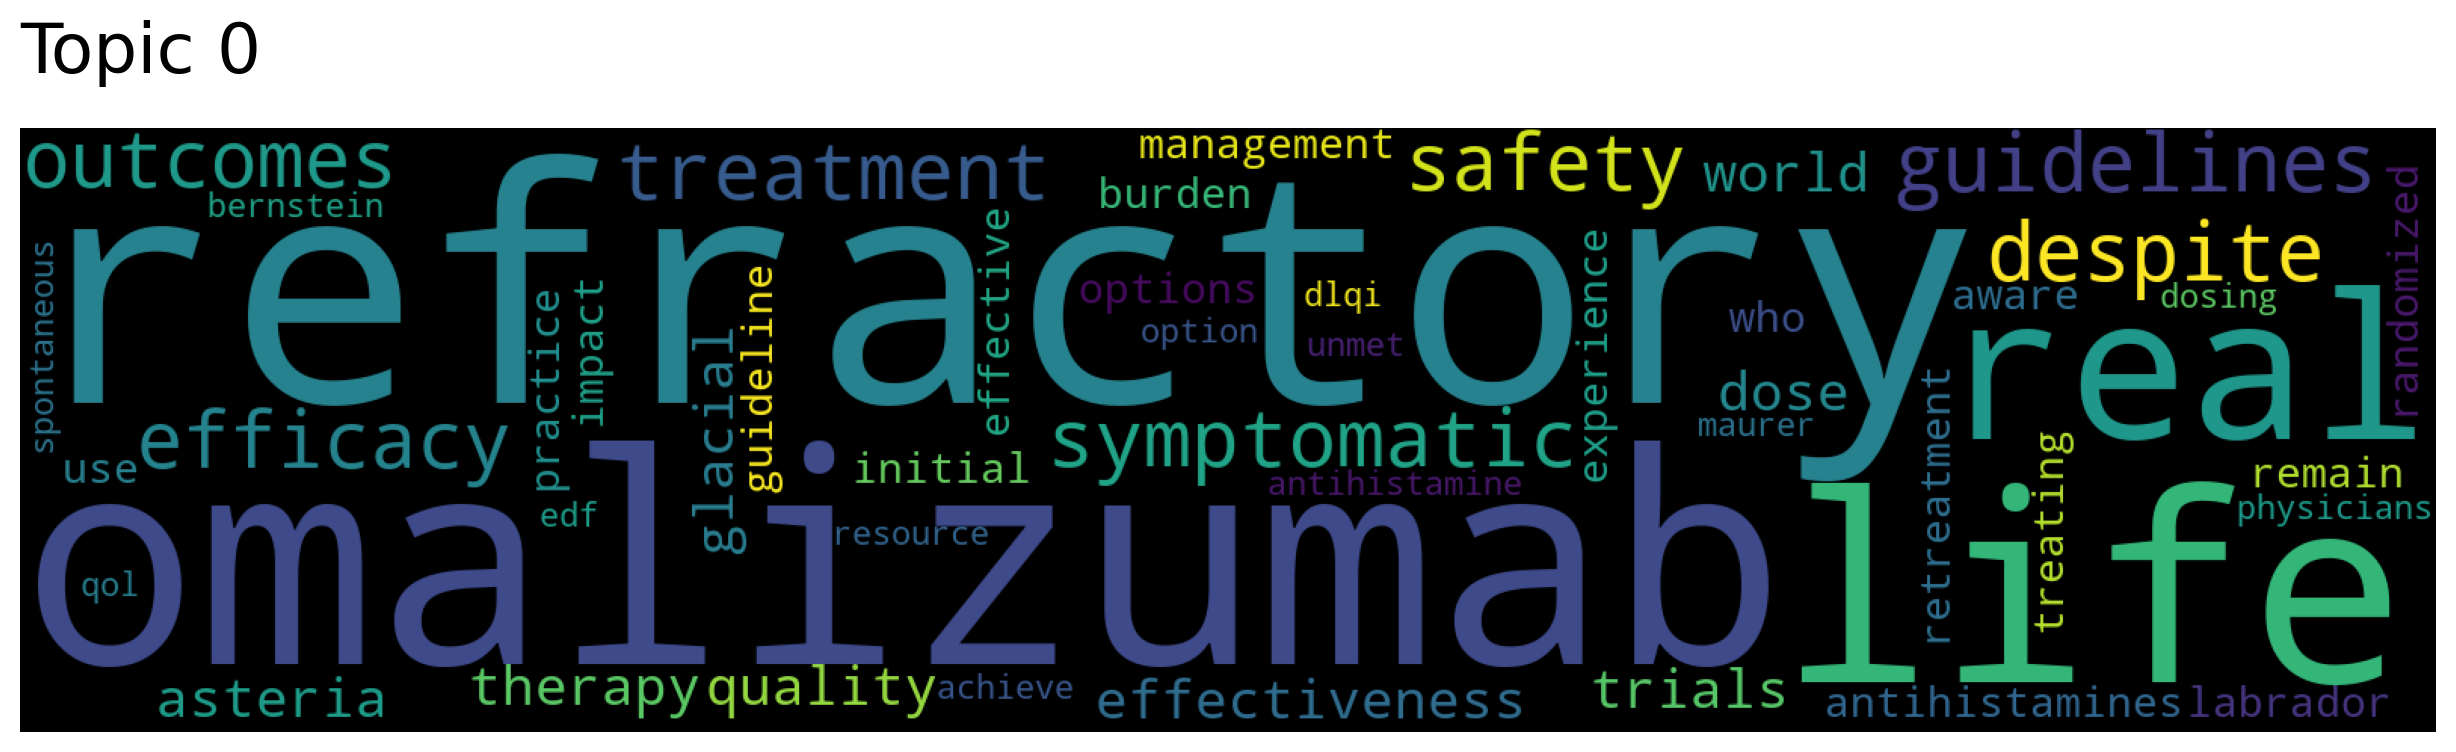

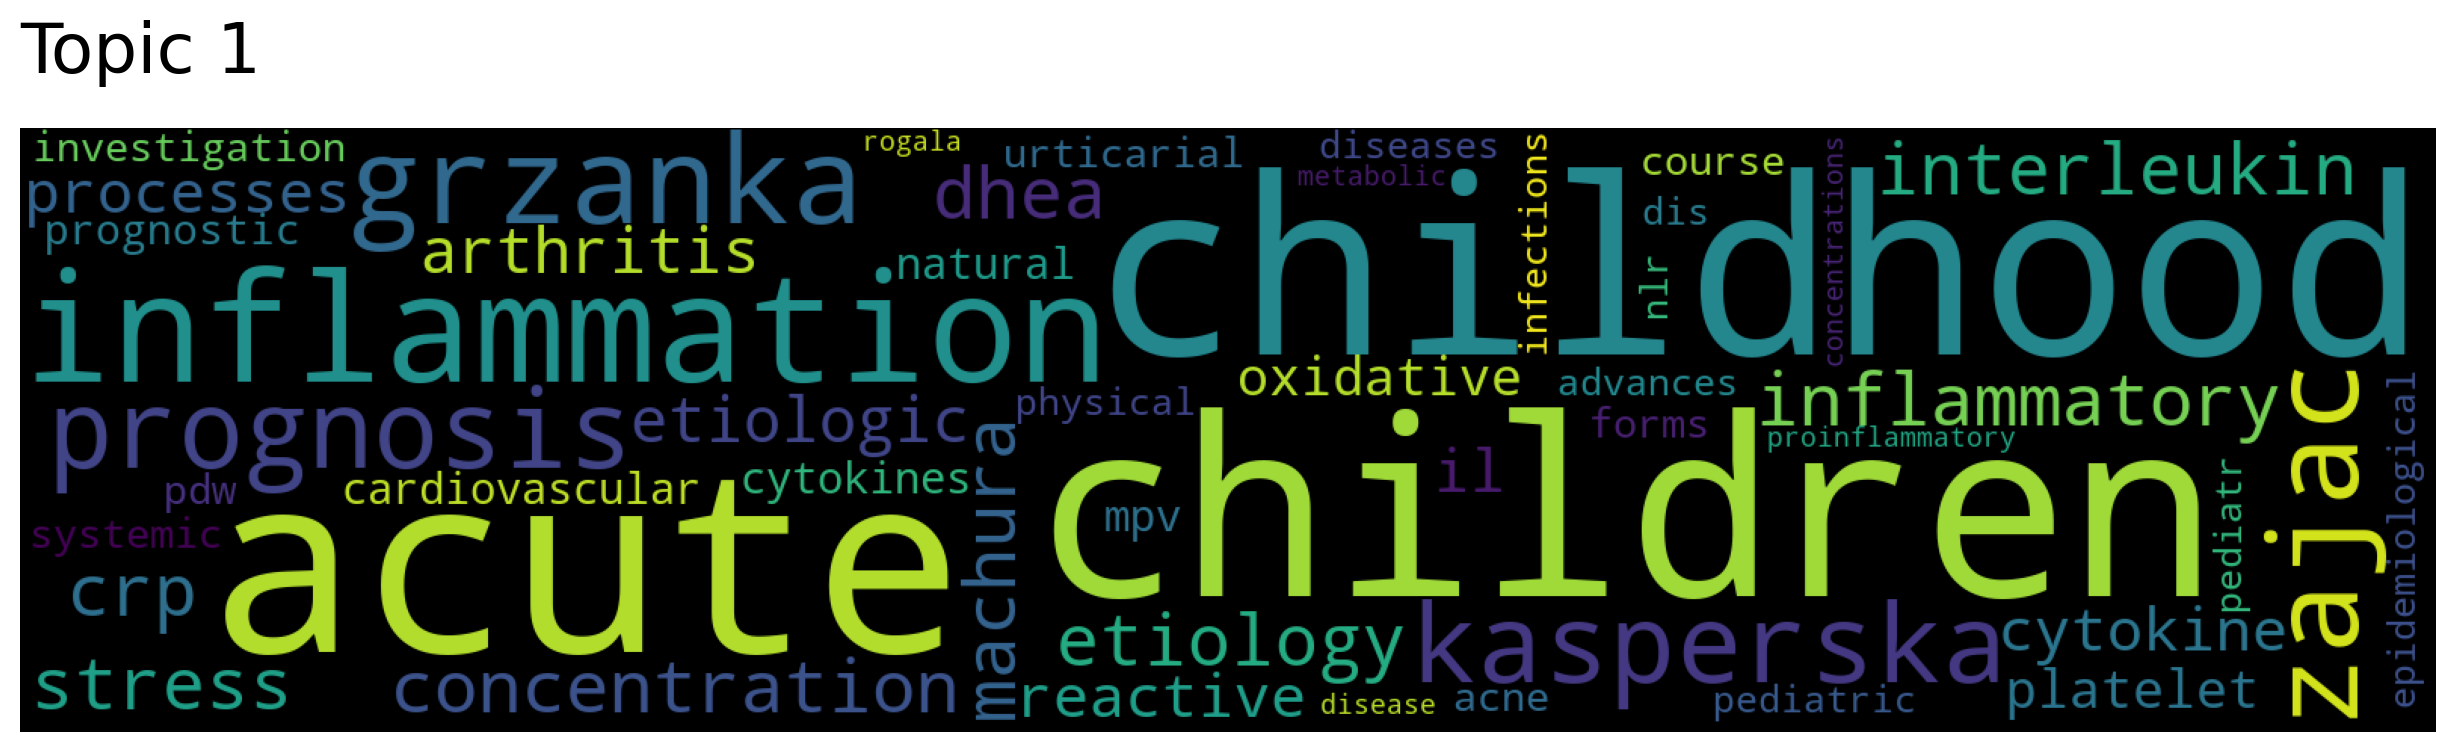

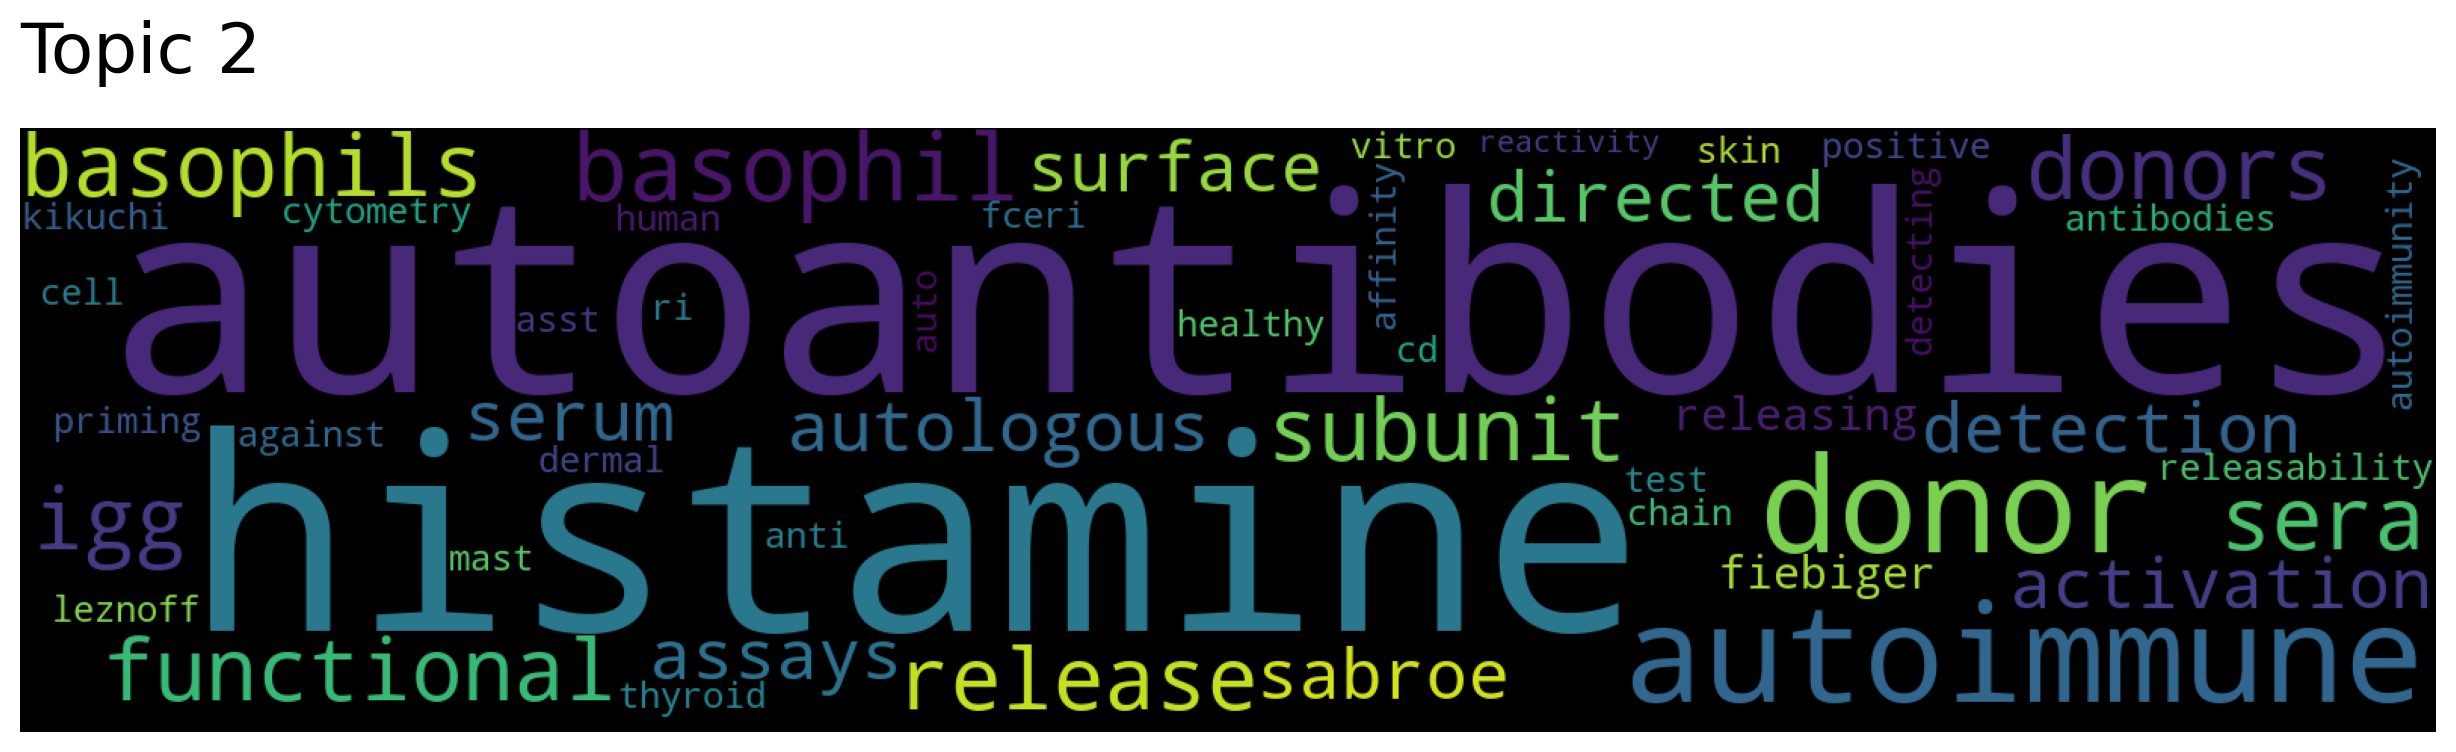

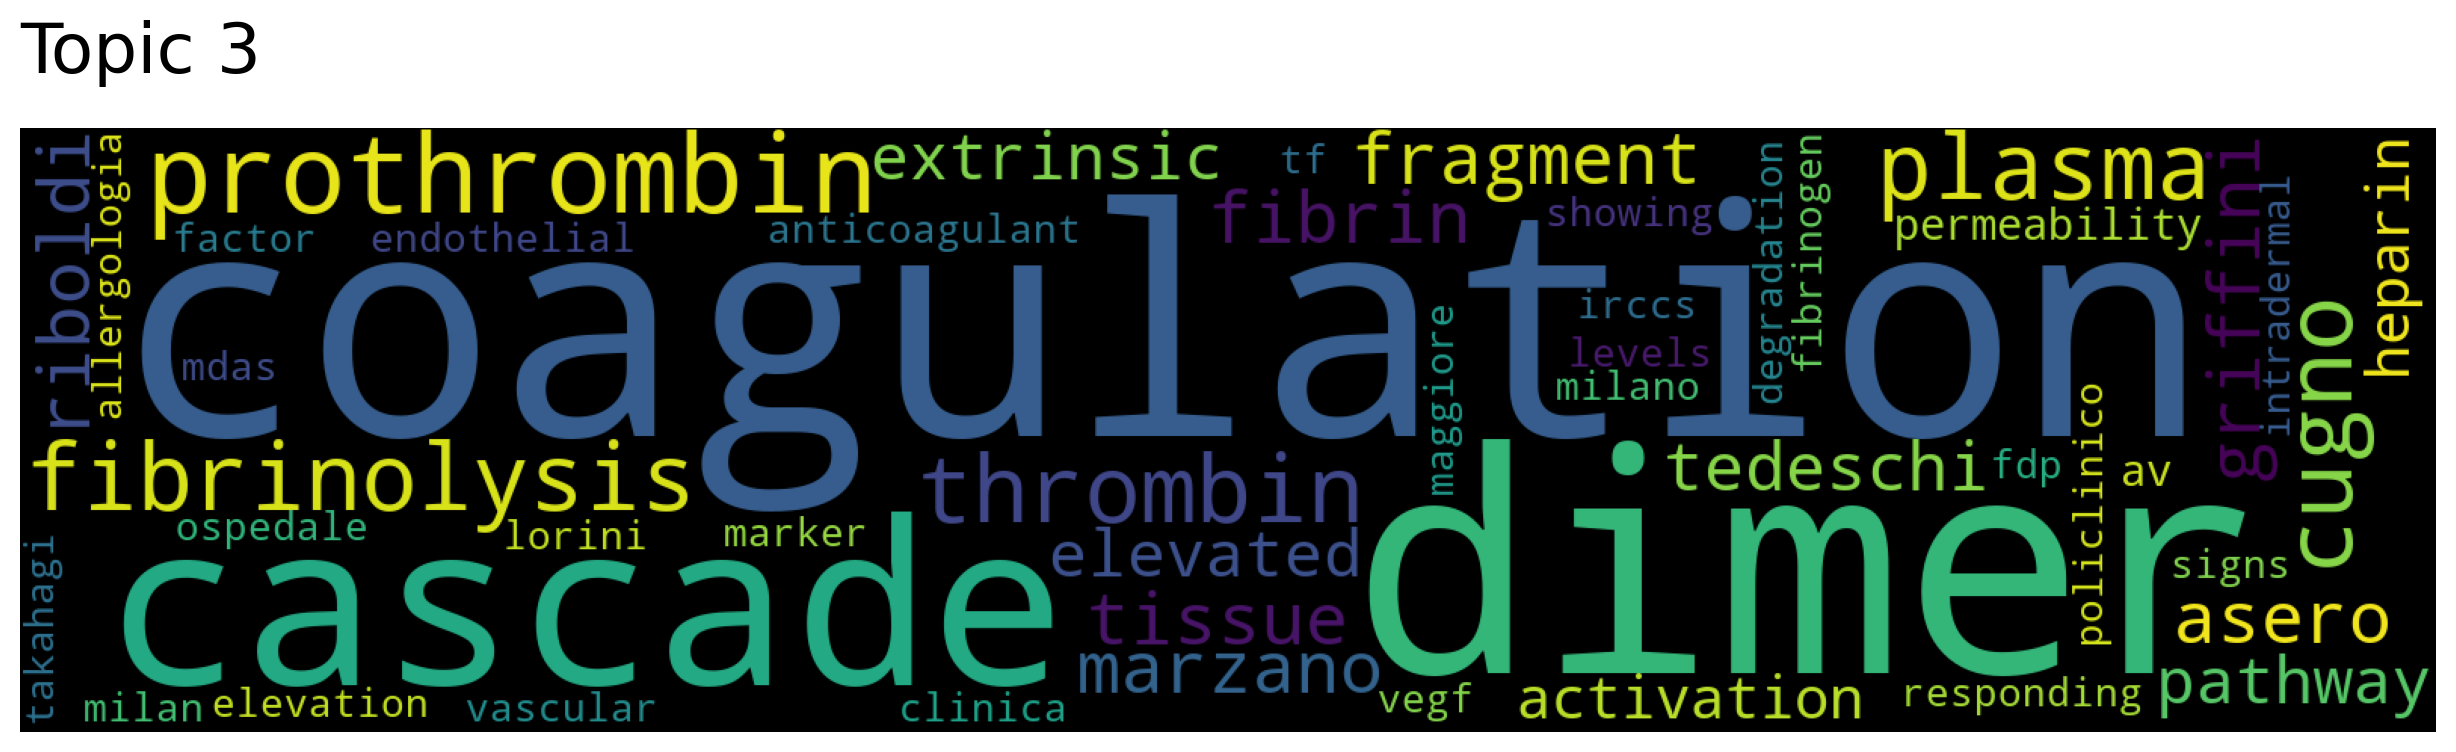

In [189]:
for topic in topic_nums:
    model.generate_topic_wordcloud(topic)

In [ ]:
#Erstellen einer Liste aller Wörter die im Corpus vorkommen
corpus_words = [corpus.split(' ') for corpus in df['Corpus']]
flat_corpus_words = list(set([item for corpus in corpus_words for item in corpus]))
flat_corpus_words

keywords = [tag.split(' ') for tag in tags] #basierend auf den distict Tags der Corpora, tags entspricht dem zu beginn definierten Set.
flat_keywords = [item for sublist in keywords for item in sublist]

present_keywords = list(set([word.lower() for word in flat_keywords if word.lower() in flat_corpus_words])) #Behalten der Keywords / Tags die selbst im Corpus auftreten.

In [268]:
similarity_dict = []
for keyword in present_keywords:
  words, word_scores = model.similar_words(keywords=[keyword], keywords_neg=[], num_words=20)
  similarity_dict.append({keyword:dict(zip(words,word_scores))})

In [277]:
similarity_dict

[{'cyclosporine': {'alternative': 0.39729435360119664,
   'antihistamines': 0.3612761138010636,
   'azathioprine': 0.4499463481363567,
   'corticosteroids': 0.3514195937608168,
   'cyclosporin': 0.4450752354621159,
   'dapsone': 0.342457573855102,
   'dose': 0.37481775761522346,
   'doses': 0.3492393194976422,
   'intravenous': 0.33512751900784793,
   'low': 0.3725443281016626,
   'methotrexate': 0.4904759521690869,
   'montelukast': 0.3409962179023265,
   'mycophenolate': 0.42818090309898993,
   'option': 0.4645681326264033,
   'oral': 0.35780967255637075,
   'short': 0.39868997942760187,
   'sulfasalazine': 0.40186670513607864,
   'term': 0.38358064641676515,
   'therapy': 0.3786552306051816,
   'treatment': 0.4243194170444978}},
 {'tpo': {'anti': 0.4958688785535836,
   'antibodies': 0.3759327919239219,
   'antigens': 0.356213868806374,
   'antithyroid': 0.33945538283519244,
   'asst': 0.31031558240996215,
   'elevation': 0.3443809711442049,
   'exacerbation': 0.3875175231451874,
   

### TFIDF Vertorizer

In [83]:
#@title Dateiinhalt, Korpus oder Korpus mit Satzzeichen
src = 'Corpus_w_Punctuation' #@param {type:"string"}
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,1)).fit(df[src].values)

In [84]:
len(tfidf_vectorizer.vocabulary_)

15875

In [85]:
tfidf_vectors = tfidf_vectorizer.fit_transform(df['Corpus'].values)

In [86]:
# get the first vector out (for the first document) 
first_vector_tfidfvectorizer=tfidf_vectors[0]
df_tfidf_sample = pd.DataFrame(first_vector_tfidfvectorizer.T.todense(), index=tfidf_vectorizer.get_feature_names(), columns=["tfidf"]) 
df_tfidf_sample.sort_values(by=["tfidf"],ascending=False)

,tfidf
kendall,0.198696
tapered,0.164733
ta,0.155839
eventually,0.152198
neg,0.152198
...,...
fep,0.000000
fer,0.000000
fereshteh,0.000000
ferguson,0.000000


### K-Means Clustering

In [88]:
from sklearn.cluster import KMeans

K-Means für mehrere k's berechnen und anschließend plotten

In [89]:
Sum_of_squared_distances = []
max_range = 10
K = range(1,max_range + 1)
for k in K: 
    print(str(k) + "/" + str(max_range))
    km = KMeans(n_clusters=k)
    km = km.fit(tfidf_vectors)
    Sum_of_squared_distances.append(km.inertia_)
    

1/10
2/10
3/10
4/10
5/10
6/10
7/10
8/10
9/10
10/10


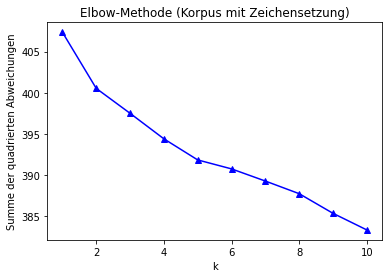

In [90]:
plt.plot(K,Sum_of_squared_distances, 'b^-')
plt.xlabel('k')
plt.ylabel('Summe der quadrierten Abweichungen')
plt.title('Elbow-Methode (Korpus mit Zeichensetzung)')
plt.show()

Wortsammlungen erstellen durch angabe der Idealen Clusterzahl im Formularfeld

In [91]:
#@title Anzahl der Cluster gem. Elbow-Curve
k = 2#@param {type:"integer"}

km = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=1,
                verbose=1)

In [92]:
#https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html
km = km.fit(words_transformed)
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = tfidfconvert.get_feature_names()

clustered_words = []
for i in range(k):
  words_per_cluster = []
  for ind in order_centroids[i, :20]:
    words_per_cluster.append(terms[ind])
  clustered_words.append(words_per_cluster)

Initialization complete
Iteration  0, inertia 797.181
Iteration  1, inertia 400.471
Iteration  2, inertia 399.513
Iteration  3, inertia 399.299
Iteration  4, inertia 399.227
Iteration  5, inertia 399.119
Iteration  6, inertia 399.020
Iteration  7, inertia 398.996
Converged at iteration 7: center shift 0.000000e+00 within tolerance 5.630529e-09


In [ ]:
#clustered_words Liste transponieren
clustered_words = list(map(list, zip(*clustered_words)))

#Dataframe aus clustered_words erstellen
cluster_names = ['Cluster %s' %i for i in range(1,k+1)]
df_clustered_words = pd.DataFrame(data=clustered_words, columns=cluster_names)
df_clustered_words

### **HDBSCAN**

In [94]:
!pip install hdbscan

In [124]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('allenai-specter')
embeddings = model.encode(df['Corpus_w_Punctuation'], show_progress_bar=True)

In [152]:
import umap
umap_embeddings = umap.UMAP(n_neighbors=20, 
                            n_components=2,
                            metric='cosine').fit_transform(embeddings)

In [149]:
import hdbscan
clusterer = hdbscan.HDBSCAN(min_cluster_size=2,
                          metric='euclidean',                      
                          cluster_selection_method='eom')
cluster = clusterer.fit(umap_embeddings)

In [155]:
# Prepare data
umap_data = umap.UMAP(n_neighbors=20, n_components=2, min_dist=0.2, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

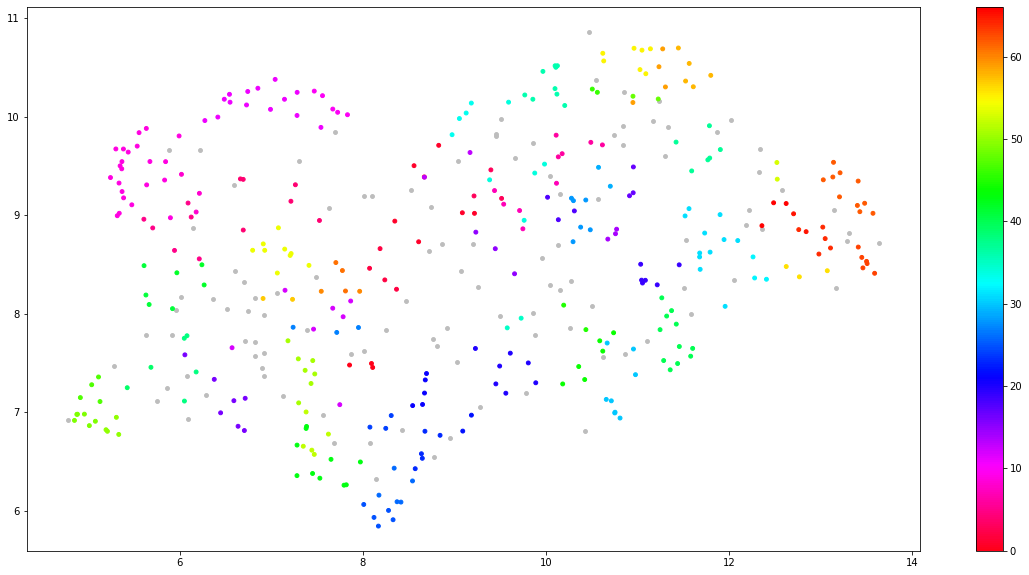

In [156]:
# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=15)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=15, cmap='hsv_r')
plt.colorbar()